In [1]:
import os
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_path = "/content/drive/MyDrive/NLP-POS"

folders = [
    f"{base_path}/data/raw",
    f"{base_path}/data/processed",
    f"{base_path}/notebooks",
    f"{base_path}/models"
]

for folder in folders:
    os.makedirs(folder, exist_ok=True)

folders


In [ ]:
raw_path = "/content/drive/MyDrive/NLP-POS/data/raw"

!wget -q https://raw.githubusercontent.com/UniversalDependencies/UD_Spanish-GSD/master/es_gsd-ud-train.conllu -O train.conllu
!wget -q https://raw.githubusercontent.com/UniversalDependencies/UD_Spanish-GSD/master/es_gsd-ud-dev.conllu -O dev.conllu
!wget -q https://raw.githubusercontent.com/UniversalDependencies/UD_Spanish-GSD/master/es_gsd-ud-test.conllu -O test.conllu

!mv train.conllu {raw_path}/train.conllu
!mv dev.conllu {raw_path}/dev.conllu
!mv test.conllu {raw_path}/test.conllu

!ls -lh {raw_path}


In [3]:
train_file = "/content/drive/MyDrive/NLP-POS/data/raw/train.conllu"
dev_file   = "/content/drive/MyDrive/NLP-POS/data/raw/dev.conllu"
test_file  = "/content/drive/MyDrive/NLP-POS/data/raw/test.conllu"


In [5]:
def read_conllu(path):
    sentences = []
    sent = []
    with open(path, encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                if sent:
                    sentences.append(sent)
                    sent = []
                continue
            if line.startswith("#"):
                continue

            cols = line.split("\t")
            if len(cols) != 10:
                continue

            token_id = cols[0]
            if "-" in token_id or "." in token_id:
                continue

            form = cols[1]
            upos = cols[3]
            sent.append((form, upos))
    if sent:
        sentences.append(sent)
    return sentences


In [6]:
train_sents = read_conllu(train_file)
dev_sents   = read_conllu(dev_file)
test_sents  = read_conllu(test_file)

len(train_sents), len(dev_sents), len(test_sents)

(14187, 1400, 427)

In [ ]:
print("Train cümle sayısı:", len(train_sents))
print("İlk cümle (kelimeler):")
print([w for w, t in train_sents[0]])
print("İlk cümle (tagler):")
print([t for w, t in train_sents[0]])

Train cümle sayısı: 14187
İlk cümle (kelimeler):
['Además', 'se', 'le', 'pediría', 'a', 'las', 'empresas', 'interesadas', 'en', 'prestar', 'el', 'servicio', 'que', 'se', 'hagan', 'cargo', 'de', 'la', 'señalización', 'y', 'la', 'cartelería', 'que', 'contiene', 'información', 'para', 'los', 'usuarios', '.']
İlk cümle (tagler):
['ADV', 'PRON', 'PRON', 'VERB', 'ADP', 'DET', 'NOUN', 'ADJ', 'ADP', 'VERB', 'DET', 'NOUN', 'SCONJ', 'PRON', 'VERB', 'NOUN', 'ADP', 'DET', 'NOUN', 'CCONJ', 'DET', 'NOUN', 'SCONJ', 'VERB', 'NOUN', 'ADP', 'DET', 'NOUN', 'PUNCT']


In [ ]:
sent_lengths = [len(s) for s in train_sents]

print("Min uzunluk:", min(sent_lengths))
print("Maks uzunluk:", max(sent_lengths))
print("Ortalama uzunluk:", sum(sent_lengths) / len(sent_lengths))


Min uzunluk: 2
Maks uzunluk: 152
Ortalama uzunluk: 26.957355325297808


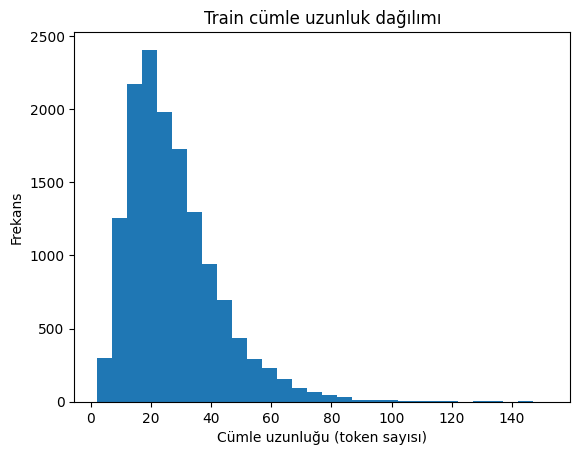

In [ ]:
plt.hist(sent_lengths, bins=30)
plt.xlabel("Cümle uzunluğu (token sayısı)")
plt.ylabel("Frekans")
plt.title("Train cümle uzunluk dağılımı")
plt.show()


In [ ]:
upos_counts = Counter()

for sent in train_sents:
    for _, tag in sent:
        upos_counts[tag] += 1

print("Toplam token:", sum(upos_counts.values()))
print("Tag sayısı:", len(upos_counts))
pprint(upos_counts.most_common())


Toplam token: 382444
Tag sayısı: 17
[('NOUN', 68743),
 ('ADP', 63005),
 ('DET', 53950),
 ('PUNCT', 42221),
 ('PROPN', 34878),
 ('VERB', 32114),
 ('ADJ', 22186),
 ('PRON', 12422),
 ('CCONJ', 12229),
 ('ADV', 11009),
 ('NUM', 9853),
 ('AUX', 9481),
 ('SCONJ', 7162),
 ('X', 1662),
 ('SYM', 1458),
 ('PART', 37),
 ('INTJ', 34)]


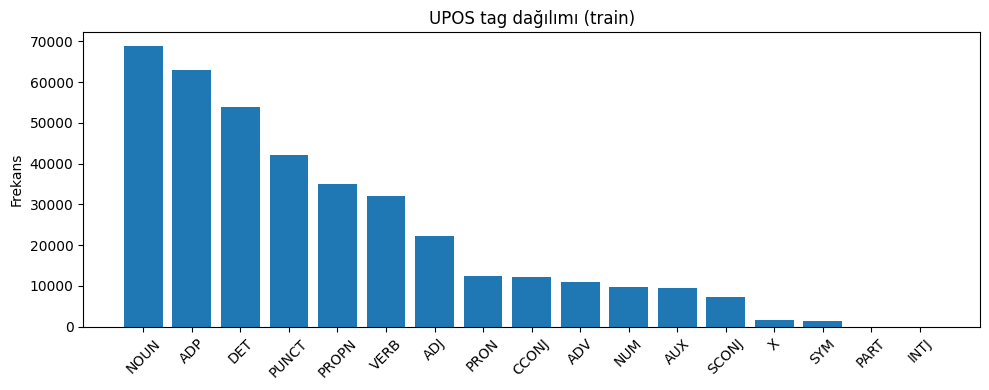

In [ ]:
tags, counts = zip(*upos_counts.most_common())

plt.figure(figsize=(10, 4))
plt.bar(tags, counts)
plt.xticks(rotation=45)
plt.ylabel("Frekans")
plt.title("UPOS tag dağılımı (train)")
plt.tight_layout()
plt.show()


In [7]:
# Kelime seti çıkar
vocab = set()
for sent in train_sents:
    for w, t in sent:
        vocab.add(w)
len(vocab)

46131

In [8]:
# Tag seti çıkar
tagset = set()
for sent in train_sents:
    for w, t in sent:
        tagset.add(t)
len(tagset)

17

In [9]:
# Mapping’leri oluştur
word2id = {"<PAD>": 0, "<UNK>": 1}
for idx, w in enumerate(sorted(vocab), start=2):
    word2id[w] = idx

id2word = {i: w for w, i in word2id.items()}

tag2id = {t: i for i, t in enumerate(sorted(tagset))}
id2tag = {i: t for t, i in tag2id.items()}

In [10]:
# Max sequence length belirle
import numpy as np

lengths = [len(s) for s in train_sents]
max_len = int(np.percentile(lengths, 95))
max_len

56

In [12]:
# Padding + ID mapping uygulama
def encode_and_pad(sentences, word2id, tag2id, max_len):
    X = []
    y = []
    for sent in sentences:
        words = [w for w, t in sent]
        tags  = [t for w, t in sent]

        word_ids = [word2id.get(w, 1) for w in words]   # UNK = 1
        tag_ids  = [tag2id[t] for t in tags]

        # padding
        if len(word_ids) < max_len:
            pad_len = max_len - len(word_ids)
            word_ids += [0] * pad_len
            tag_ids  += [-1] * pad_len
        else:
            word_ids = word_ids[:max_len]
            tag_ids  = tag_ids[:max_len]

        X.append(word_ids)
        y.append(tag_ids)

    return np.array(X), np.array(y)

In [13]:
X_train, y_train = encode_and_pad(train_sents, word2id, tag2id, max_len)
X_dev, y_dev     = encode_and_pad(dev_sents, word2id, tag2id, max_len)
X_test, y_test   = encode_and_pad(test_sents, word2id, tag2id, max_len)

In [14]:
import pickle
import numpy as np
import json

processed_path = "/content/drive/MyDrive/NLP-POS/data/processed"

np.save(f"{processed_path}/X_train.npy", X_train)
np.save(f"{processed_path}/y_train.npy", y_train)
np.save(f"{processed_path}/X_dev.npy", X_dev)
np.save(f"{processed_path}/y_dev.npy", y_dev)
np.save(f"{processed_path}/X_test.npy", X_test)
np.save(f"{processed_path}/y_test.npy", y_test)

with open(f"{processed_path}/word2id.pkl", "wb") as f:
    pickle.dump(word2id, f)

with open(f"{processed_path}/id2word.pkl", "wb") as f:
    pickle.dump(id2word, f)

with open(f"{processed_path}/tag2id.pkl", "wb") as f:
    pickle.dump(tag2id, f)

with open(f"{processed_path}/id2tag.pkl", "wb") as f:
    pickle.dump(id2tag, f)

with open(f"{processed_path}/max_len.json", "w") as f:
    json.dump({"max_len": max_len}, f)
